# Работа Милюшков Георгий, биржевой трейдер

### Добавляем нужные библиотеки

In [64]:
import time
import datetime
import numpy as np
import pandas  as pd
import matplotlib.pyplot as plt
import data_process as d
import pandas_datareader.data as web 
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()
from datetime import datetime

%matplotlib inline

### Нужные функции

In [173]:
#Создаем Q-таблицу. Создается Q матрица заполненная случайными малыми значениями
def initialize_q_mat(all_states, all_actions): 
    states_size = len(all_states)
    actions_size = len(all_actions)
    
    q_mat = np.random.rand(states_size, actions_size)/1e9
    q_mat = pd.DataFrame(q_mat, columns=all_actions.keys())
    
    q_mat['states'] = all_states
    q_mat.set_index('states', inplace=True)
    
    return q_mat

#Функция действий. Выполняется действия в зависимости от стратегий: Либо случайное действие либо
# с максимальным будущим возвратом
def act(state, q_mat, threshold=0.2, actions_size=3):
    if np.random.uniform(0,1) < threshold: 
        action = np.random.randint(low=0, high=actions_size)  
    else:
        action = np.argmax(q_mat.loc[state].values)
    return action

#Считается возврат
def get_return_since_entry(bought_history, current_adj_close):
    return_since_entry = 0.
    
    for b in bought_history:
        return_since_entry += (current_adj_close - b)
    return return_since_entry

#Визуализация результатов
def visualize_results(actions_history, returns_since_entry):
    f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,12))
    
    ax1.plot(returns_since_entry)
    
    days, prices, actions = [], [], []
    for d, p, a in actions_history:
        days.append(d)
        prices.append(p)
        actions.append(a)

    ax2.plot(days, prices, label='normalized adj close price')
    hold_d, hold_p, buy_d, buy_p, sell_d, sell_p = [], [], [], [], [], []
    for d, p, a in actions_history:
        if a == 0:
            hold_d.append(d)
            hold_p.append(p)
        if a == 1:
            buy_d.append(d)
            buy_p.append(p)
        if a == 2:
            sell_d.append(d)
            sell_p.append(p)
        
    ax2.scatter(hold_d, hold_p, color='blue', label='hold')
    ax2.scatter(buy_d, buy_p, color='green', label='buy')
    ax2.scatter(sell_d, sell_p, color='red', label='sell')
    ax2.legend()
    
#получить ивестиционный капитал
def get_invested_capital(actions_history, returns_since_entry):
    invest = []
    total = 0
    return_invest_ratio = None
    for i in range(len(actions_history)):
        a = actions_history[i][2]
        p = actions_history[i][1]

        try:
            next_a = actions_history[i+1][2]
        except:
            #print('end')
            break
        if a == 1:
            total += p
            #print(total)
            if next_a != 1 or (i==len(actions_history)-2 and next_a==1):
                invest.append(total)
                total = 0
    if invest:
        return_invest_ratio = returns_since_entry[-1]/max(invest)
        print('invested capital {}, return/invest ratio {}'.format(max(invest), return_invest_ratio))
    else:
        print('no buy transactions, invalid training')
    return return_invest_ratio


#Посчитать прибыльность по базовой метрике       
def get_base_return(data):
    
    start_price, _ = data[0]
    end_price, _ = data[-1]
    return (end_price - start_price)/start_price

### Получаем данные из Yahoo finance компании Apple, разбивая на 80% 

In [174]:
y_symbols = ['AAPL']
startdate = datetime(2014, 1, 1)
enddate = datetime(2017, 4, 12)

startdate1 = datetime(2017, 4, 13)
enddate1 = datetime(2018, 1, 1)

train_df = pdr.get_data_yahoo(y_symbols, start=startdate, end=enddate)
test_df = pdr.get_data_yahoo(y_symbols, start=startdate1, end=enddate1)
#train_df, test_df = d.get_stock_data('AAPL',start, end, 0.8)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


### Смотрим на таблицу данных

In [175]:
train_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,19.845715,19.893929,19.715000,19.754642,17.296654,234684800
2014-01-03,19.745001,19.775000,19.301071,19.320715,16.916721,392467600
2014-01-06,19.194643,19.528570,19.057142,19.426071,17.008974,412610800
2014-01-07,19.440001,19.498571,19.211430,19.287144,16.887329,317209200
2014-01-08,19.243214,19.484285,19.238930,19.409286,16.994267,258529600


### Создается случайное блуждание для проверки правильности, где средняя прибыль должна быть 0

In [213]:
random_walk=[]
N=1000

In [214]:
for i in range(0,N,1):
    # Задаем параметры
    num_steps = 800  # количество шагов
    mu, sigma = 0, 1  # среднее и стандартное отклонение нормального распределения

    # Генерируем случайные шаги
    steps = np.random.normal(0, 1, num_steps)

    # Строим временной ряд случайного блуждания
    random_walk.append(np.cumsum(steps)+100)


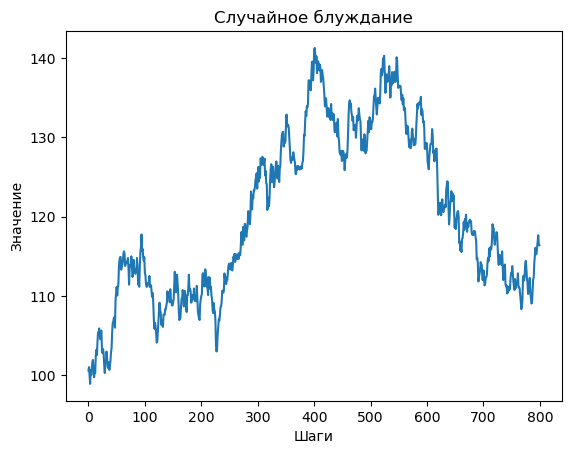

In [215]:
# Визуализируем случайной результат случайного блуждания
t=np.random.randint(0,N-1)

plt.plot(random_walk[t])
plt.title('Случайное блуждание')
plt.xlabel('Шаги')
plt.ylabel('Значение')
plt.show()

In [216]:
#Создаем датфрейм для удобной работы со случайным блужданием
dfrw=[]
for j in range(N):
    df0=pd.DataFrame(random_walk[j],columns=["Adj Close"])
    dfrw.append(df0)


In [217]:
dfrw[2].head()

,Adj Close
0,97.768764
1,98.424431
2,98.937273
3,99.558269
4,98.937081


In [218]:
#Для тестовых данных
test_df = d.create_df(test_df, 3)
test_df = d.create_state_df(test_df, price_states_value, bb_states_value, close_sma_ratio_states_value)

In [219]:
#Нужные функции из data_process для случайного блуждания, так как нет 
#технических индекаторов для вызова напрямую из файла

#Дискретезируем данные на целочисленные, для использование в состоянии.
def discretize(values, num_states=10):
   
    states_value = dict()
    step_size = 1./num_states
    for i in range(num_states):
        if i == num_states - 1:
            states_value[i] = values.max()
        else:
            states_value[i] = values.quantile((i+1)*step_size)
    return states_value

#Превращаем значения в состояния
def value_to_state(value, states_value):

    if np.isnan(value):
        return np.nan
    else:
        for state, v in states_value.items():
            if value <= v:
                return str(state)
        return 'value out of range'


In [220]:
#Добавляем в датафрейм элементарные технические индекаторы и состояния
all_actions = {0:'hold', 1:'buy', 2:'sell'}

train_df = d.create_df(train_df, 3)
price_states_value, bb_states_value, close_sma_ratio_states_value = d.get_states(train_df)
train_df = d.create_state_df(train_df, price_states_value, bb_states_value, close_sma_ratio_states_value)

all_states = d.get_all_states(price_states_value, bb_states_value, close_sma_ratio_states_value)
states_size = len(all_states)

#Для случайных блужданий нормируем цены и добавляем состояние
for i in range(N):
    dfrw[i]['norm_adj_close'] = dfrw[i]['Adj Close']/dfrw[i].iloc[0,:]['Adj Close']
    price_states_value = discretize(dfrw[i]['norm_adj_close'])
    dfrw[i]['norm_adj_close_state'] = dfrw[i]['norm_adj_close'].apply(lambda x : value_to_state(x, price_states_value))    


In [221]:
# Для случайного случайного блуждания печатаем датафрейм
t=np.random.randint(0,N-1)
dfrw[t].head()

,Adj Close,norm_adj_close,norm_adj_close_state
0,101.267932,1.000000,1
1,98.746399,0.975100,0
2,97.226022,0.960087,0
3,97.320136,0.961016,0
4,96.152231,0.949484,0


### Основыные функции

In [222]:
#тренеруем Q-таблицу
def train_q_learning(train_data, q, alpha, gamma, episodes):
    
    actions_history = []
    num_shares = 0
    bought_history = []
    returns_since_entry = [0]
    
    for ii in range(episodes):
        actions_history = []
        num_shares = 0
        bought_history = []
        returns_since_entry = [0]
        days=[0]
        for i, val in enumerate(train_data):
            current_adj_close, state = val
            try:
                next_adj_close, next_state = train_data[i+1]
            except:
                break

            if len(bought_history) > 0:
                returns_since_entry.append(get_return_since_entry(bought_history, current_adj_close)) 
            else:
                returns_since_entry.append(returns_since_entry[-1])

            # Решаем действие 
            if alpha > 0.1:
                alpha = alpha/(i+1)
            action = act(state, q, threshold=alpha, actions_size=3)

            # Получаем награду
            if action == 0: # Удерживаем акции
                if num_shares > 0:
                    prev_adj_close, _ = train_data[i-1]
                    future = next_adj_close - current_adj_close 
                    past = current_adj_close - prev_adj_close
                    reward = past
                else:
                    reward = 0

            if action == 1: # Покупаем акции
                reward = 0
                num_shares += 1
                bought_history.append((current_adj_close))       

            if action == 2: # Продаем акции
                if num_shares > 0:
                    bought_price = bought_history[0]
                    reward = (current_adj_close - bought_price)
                    bought_history.pop(0)
                    num_shares -= 1

                else: # Чтобы не было привычки брать в долг, продаем только когда есть
                    reward = -100
            actions_history.append((i, current_adj_close, action))
            
            # Обновляем Q-таблицу
            q.loc[state, action] = (1.-alpha)*q.loc[state, action] + alpha*(reward+gamma*(q.loc[next_state].max()))
    #print('Конец тренировки!')
    return q, actions_history, returns_since_entry

#Оцениваем Q-таблицу
def eval_q_learning(test_data, q):
    actions_history = []
    num_shares = 0
    returns_since_entry = [0]
    bought_history = []
    
    for i, val in enumerate(test_data):
        current_adj_close, state = val
        try:
            next_adj_close, next_state = test_data[i+1]
        except:
            print('End of data! Done!')
            break   

        if len(bought_history) > 0:
            returns_since_entry.append(get_return_since_entry(bought_history, current_adj_close)) 
        else:
            returns_since_entry.append(returns_since_entry[-1])

        # Принимаем решение
        action = act(state, q, threshold=0, actions_size=3)

        if action == 1: # Покупаем
            num_shares += 1
            bought_history.append((current_adj_close))
        if action == 2: # Продаем
            if num_shares > 0:
                bought_price = bought_history[0]
                bought_history.pop(0)
                num_shares -= 1

        actions_history.append((i, current_adj_close, action))

    return actions_history, returns_since_entry


In [223]:
train_df.head()

,Open,High,Low,Close,Adj Close,Volume,bb_width,close_sma_ratio,norm_adj_close,norm_bb_width,norm_close_sma_ratio,bb_width_state,close_sma_ratio_state,norm_adj_close_state,state
Date,,,,,,,,,,,,,,,
2014-01-10,19.279642,19.314285,18.968214,19.033571,16.665308,304976000,0.01990,0.99126,1.000000,1.000000,1.000000,0,0,0,000
2014-01-13,18.925358,19.375000,18.924286,19.133215,16.752552,378492800,0.00703,1.00125,1.005235,0.353266,1.010078,0,1,0,010
2014-01-14,19.222143,19.526072,19.202143,19.513929,17.085896,332561600,0.02637,1.01493,1.025237,1.325126,1.023879,0,7,0,070
2014-01-15,19.768572,20.007143,19.702143,19.905714,17.428926,391638800,0.03958,1.01988,1.045821,1.988945,1.028872,0,8,0,080
2014-01-16,19.817858,19.887501,19.702856,19.794643,17.331680,229278000,0.02046,1.00286,1.039986,1.028141,1.011702,0,1,0,010


In [224]:
#Случайным образом создаем q-таблицу
np.random.seed(12)
q_init = initialize_q_mat(train_df['norm_adj_close_state'].unique(), all_actions)
print('Initializing q')
print(q_init)

Initializing q
                   0             1             2
states                                          
0       1.541628e-10  7.400497e-10  2.633150e-10
1       5.337394e-10  1.457496e-11  9.187470e-10
2       9.007149e-10  3.342143e-11  9.569493e-10
3       1.372093e-10  2.838284e-10  6.060832e-10
4       9.442251e-10  8.527355e-10  2.259234e-12
5       5.212260e-10  5.520376e-10  4.853774e-10
6       7.681342e-10  1.607168e-10  7.645605e-10
7       2.080980e-11  1.352102e-10  1.162730e-10
8       3.098976e-10  6.714526e-10  4.712298e-10
9       8.161683e-10  2.895868e-10  7.331260e-10


In [225]:
#тренируем нашу систему
train_data = np.array(train_df[['norm_adj_close', 'norm_adj_close_state']])
q, train_actions_history, train_returns_since_entry = train_q_learning(train_data, q_init, 
                                                                      alpha=0.8, gamma=0.95, episodes=1)

#Тренируем случайные блуждания
q0=[]
train_actions_history0=[]
train_returns_since_entry0=[]
for k in range(N):
    train_data1=np.array(dfrw[k][['norm_adj_close', 'norm_adj_close_state']])
    q1, train_actions_history1, train_returns_since_entry1=train_q_learning(train_data1,q_init,alpha=0.8, gamma=0.95, 
                                                                            episodes=1)
    q0.append(q1)
    train_actions_history0.append(train_actions_history1)
    train_returns_since_entry0.append(train_returns_since_entry1)


### Считаем прибиль по N=100 случайнм блужданиям. Среднее должно быть 0. 

In [226]:
Summa=0
for i in range(N):
    Summa+=get_invested_capital(train_actions_history0[i], train_returns_since_entry0[i])
    
avrage=Summa/N

invested capital 43.57954273859112, return/invest ratio 0.5706676576234386
invested capital 77.54013257167458, return/invest ratio 2.4868863813188864
invested capital 82.36801817181374, return/invest ratio -1.370104518469852
invested capital 94.17878931660215, return/invest ratio -0.4360783866899313
invested capital 137.35292249408374, return/invest ratio -0.5979709390133069
invested capital 51.485081704145585, return/invest ratio -2.8209719285463137
invested capital 101.79096383488292, return/invest ratio 0.17695104807554338
invested capital 115.3620410867115, return/invest ratio 0.20493751927219303
invested capital 63.647723584459364, return/invest ratio 0.48140305253977167
invested capital 65.53166050297074, return/invest ratio -0.7848288424395118
invested capital 226.94066969050667, return/invest ratio 0.8396331805092927
invested capital 135.4808203691487, return/invest ratio 0.10364406615922866
invested capital 54.736006400243696, return/invest ratio -0.6347563471343061
invested c

### Получаем очень близкое к 0.

In [227]:
print(avrage)

0.018213703234599157


### Считаем и визуализруем тренировочные данные

invested capital 46.956939982633315, return/invest ratio 3.33202272760058
base return/invest ratio 0.9833200208619912


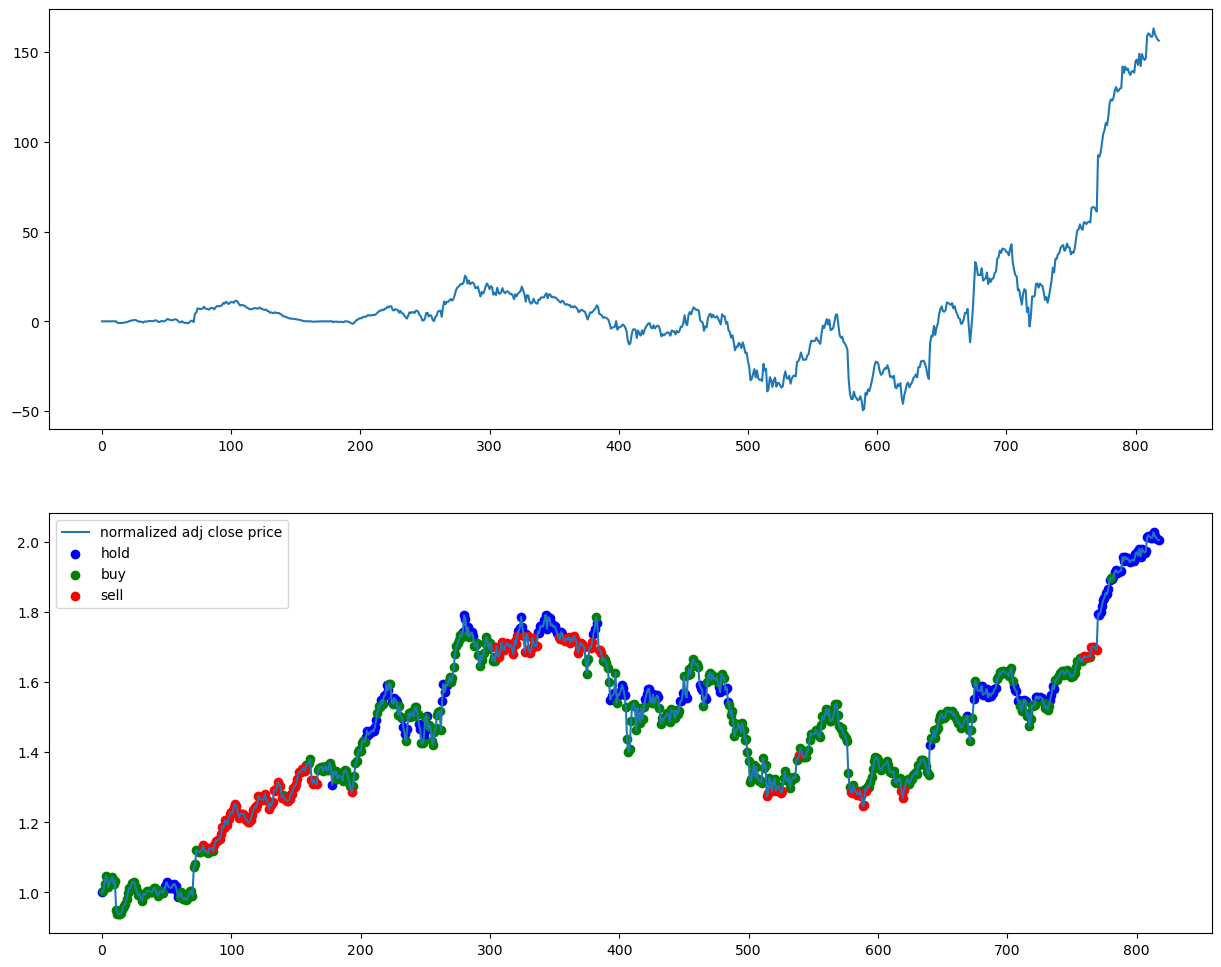

In [228]:
visualize_results(train_actions_history, train_returns_since_entry)
get_invested_capital(train_actions_history, train_returns_since_entry)
print('base return/invest ratio {}'.format(get_base_return(train_data)))

## Тестовые данные

In [229]:
test_data = np.array(test_df[['norm_adj_close', 'norm_adj_close_state']])
test_actions_history, test_returns_since_entry = eval_q_learning(test_data, q)

End of data! Done!


invested capital 148.76543015858292, return/invest ratio 0.11801385704630393
base return/invest ratio 0.19193150737153797


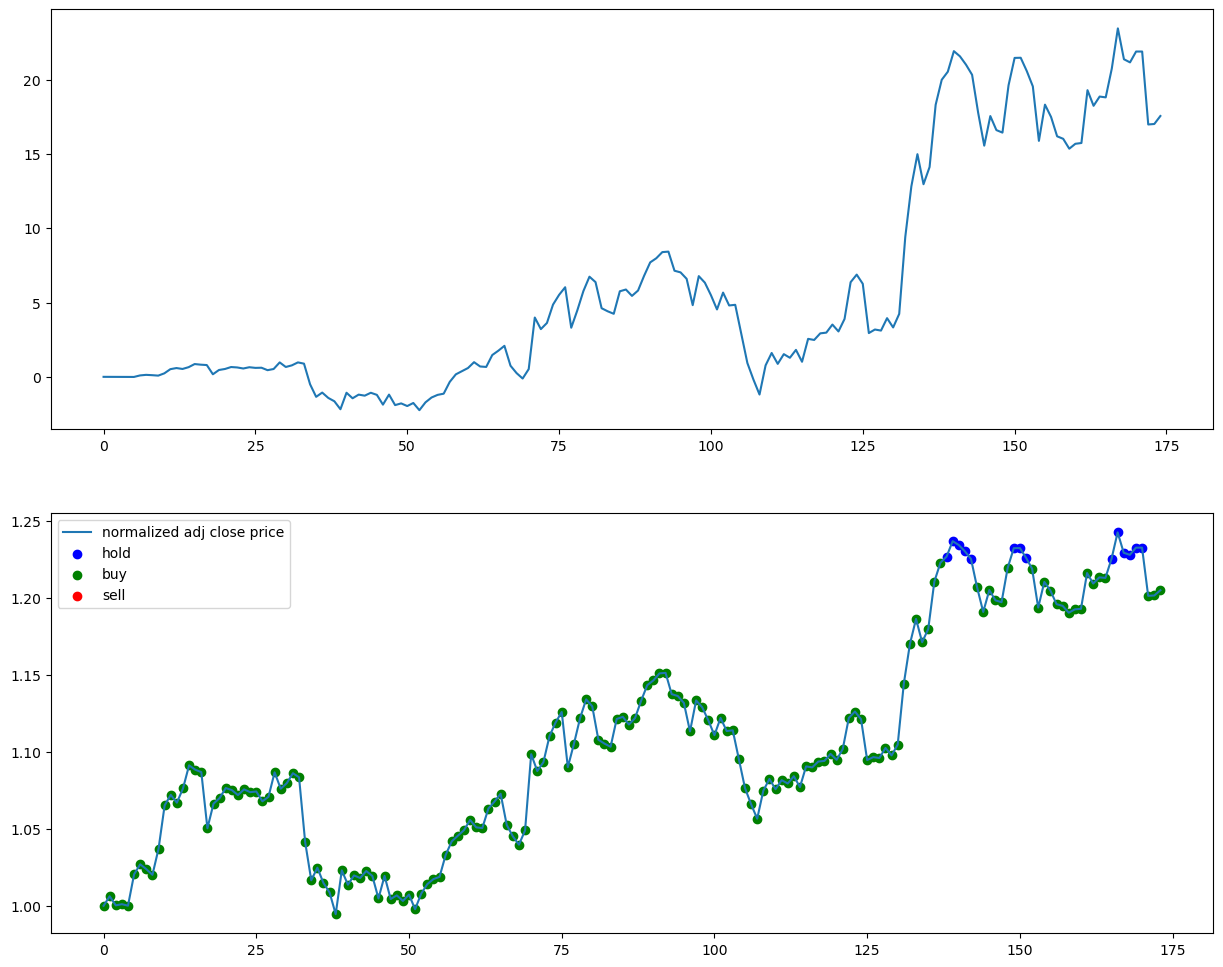

In [230]:
visualize_results(test_actions_history, test_returns_since_entry)
get_invested_capital(test_actions_history, test_returns_since_entry)
print('base return/invest ratio {}'.format(get_base_return(test_data)))

# Улучшаем модель добавляя больше циклов и тех. индекаторов

In [231]:
np.random.seed(12)
q = initialize_q_mat(all_states, all_actions)/1e9
print('Initializing q')
print(q[:3])

Initializing q
                   0             1             2
states                                          
000     1.541628e-19  7.400497e-19  2.633150e-19
001     5.337394e-19  1.457496e-20  9.187470e-19
002     9.007149e-19  3.342143e-20  9.569493e-19


In [232]:
train_data = np.array(train_df[['norm_adj_close', 'state']])
q, train_actions_history, train_returns_since_entry = train_q_learning(train_data, q, alpha=0.8, gamma=0.95, episodes=1)

invested capital 32.79631758616186, return/invest ratio 1.8580744506659421
base return/invest ratio 0.9833200208619912


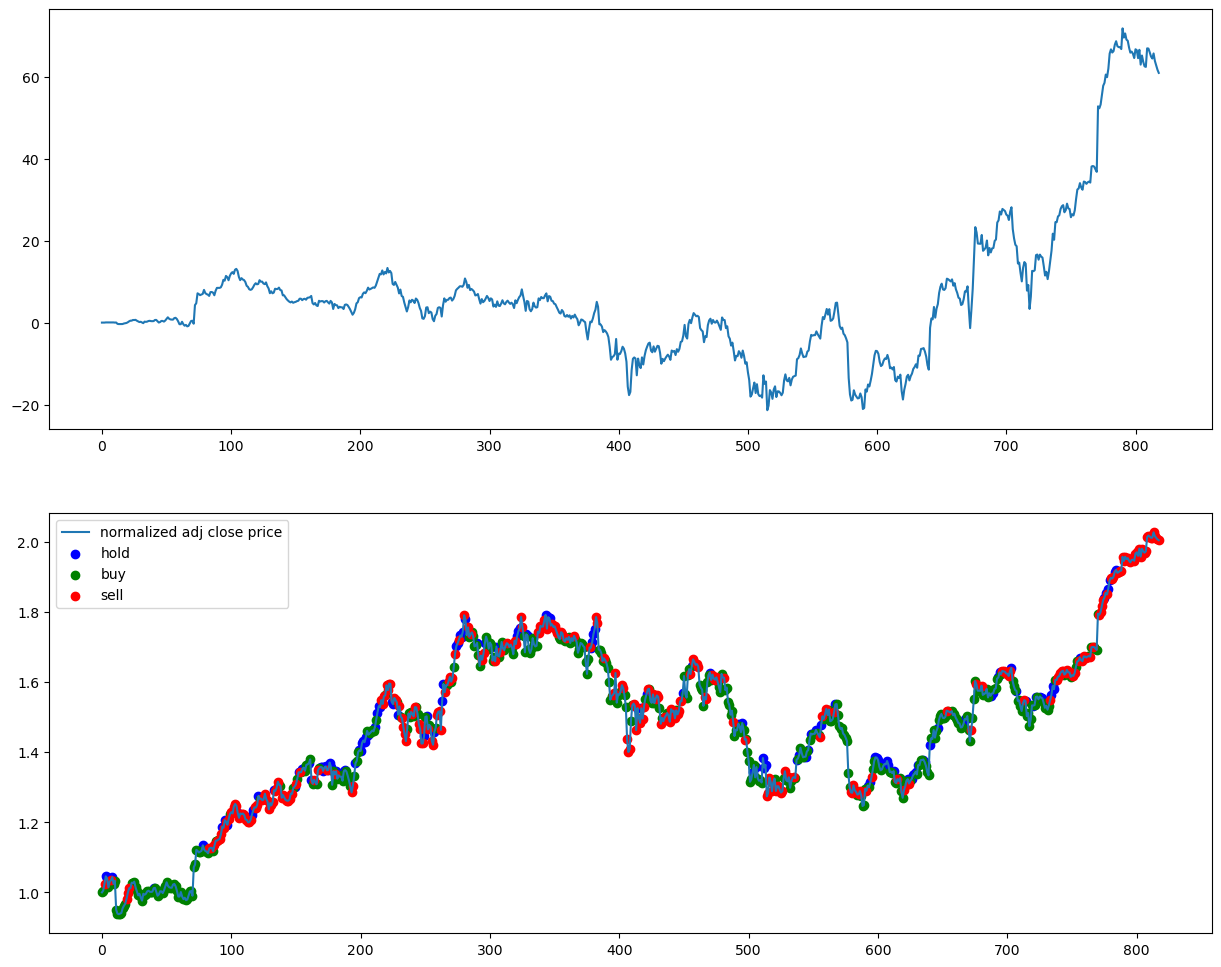

In [233]:
visualize_results(train_actions_history, train_returns_since_entry)
get_invested_capital(train_actions_history, train_returns_since_entry)
print('base return/invest ratio {}'.format(get_base_return(train_data)))

## Тестовые данные для улучшенной модели

In [234]:
test_data = np.array(test_df[['norm_adj_close', 'state']])
test_actions_history, test_returns_since_entry = eval_q_learning(test_data, q)

End of data! Done!


invested capital 6.072611085158887, return/invest ratio 0.3589693646521422
base return/invest ratio 0.19193150737153797


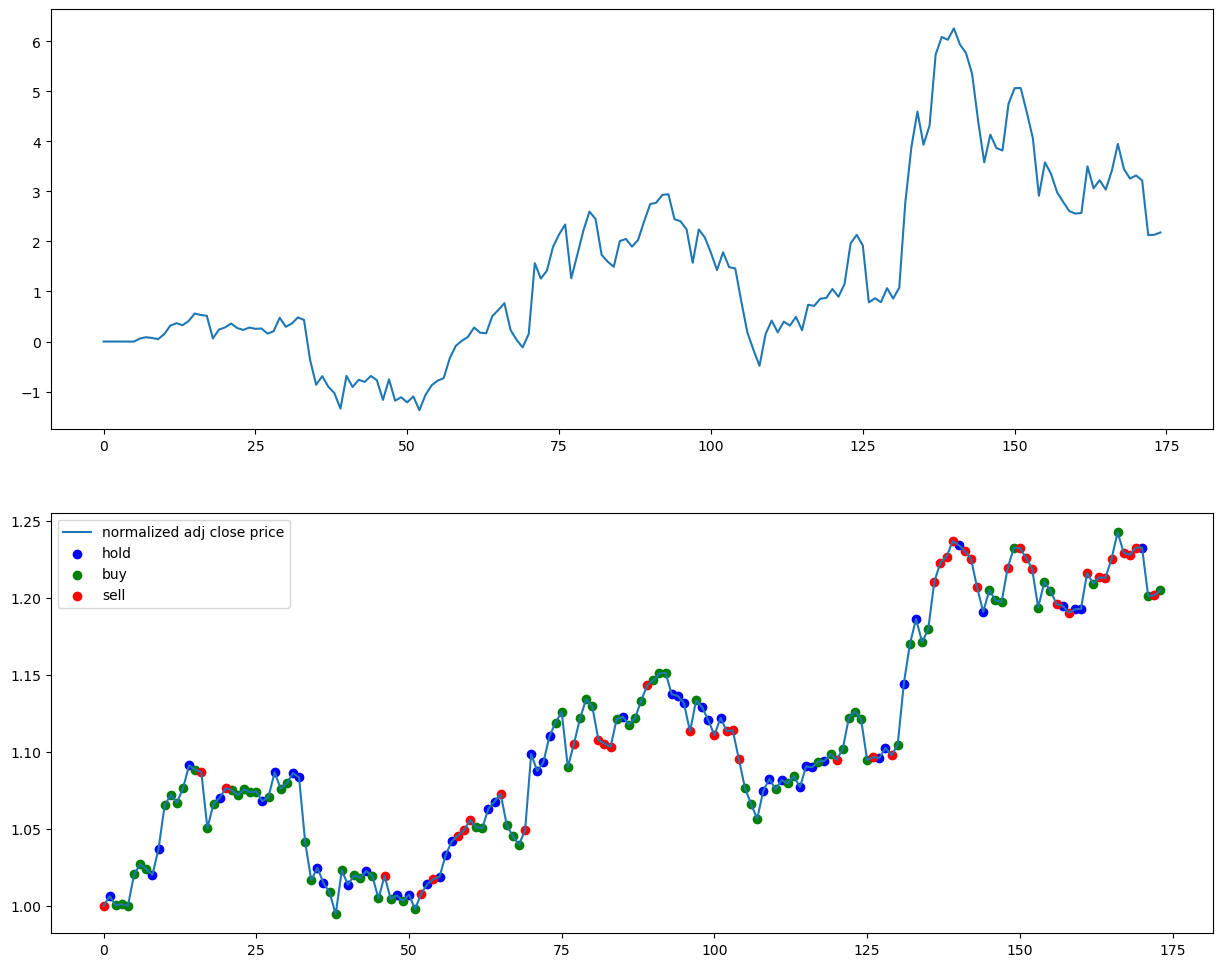

In [235]:
visualize_results(test_actions_history, test_returns_since_entry)
get_invested_capital(test_actions_history, test_returns_since_entry)
# print('invested capital {}, return/invest ratio {}'.format(invested_capital, return_invest_ratio))
print('base return/invest ratio {}'.format(get_base_return(test_data)))